In [227]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d

# Visualization parameter
plt.rcParams['figure.figsize'] = [10,6]

import random
import time

### Function Implementation
The Schwefel function is a continuous, multimodal, non-convex, deceptive (many local optima), and N-dimensional function with a global minimum of 0.

> $f_{schwefel}(x_1, x_2, ... x_N) = 418.98291 N - \sum_{i=1}^N x_i sin(\sqrt {|x_i|})$

It takes in N random numbers in a pre-defined range, processes them through the formula above, and returns a value. For example, if $N = 2$, we might randomly generate numbers $x_1 = 0$ and $x_2 = 0$, plug them into the Schwefel function, and get a value of 837.96582.

### Genetic Algorithm Goal
The goal of this project is to build a Genetic Algorithm such that, for some given number range for N random numbers, we can find a combination of N numbers to yield a value of 0 or close to 0 when inputted into our Schwefel function.

In [228]:
def schwefel(num_list):  
    return (418.98291*len(num_list)) - np.sum([x*np.sin(np.sqrt(np.absolute(x)))for x in num_list])

In [229]:
schwefel([0,0])

837.96582

Due to floating point errors, we can't *really* hit 0 consistently as `np.sin(np.pi)` yields $1.22\times10^{-16}$ where it should be 0. The value is, however, small enough to be negligible in the grand scheme of things, though.

In [230]:
schwefel([420.969 for i in range(10)])

0.00022735684069630224

Note, with a little bit of math, you can quickly find one of the solutions as all of the numbers you input into the Schwefel function is arbitrary. You can practically solve it by graphing these two equations on Desmos or whatever graphing calculator software you have.
> $y = 418.98291$

> $y = sin(\sqrt {|x_i|})$

### Quick Visualization
We can plot the full extent of the Schwefel function's range for $N = 2$ by plotting the Schwefel function value of every combination of those two numbers onto a third axis to make a 3-Dimensional visualization of the Schwefel fitness landscape.

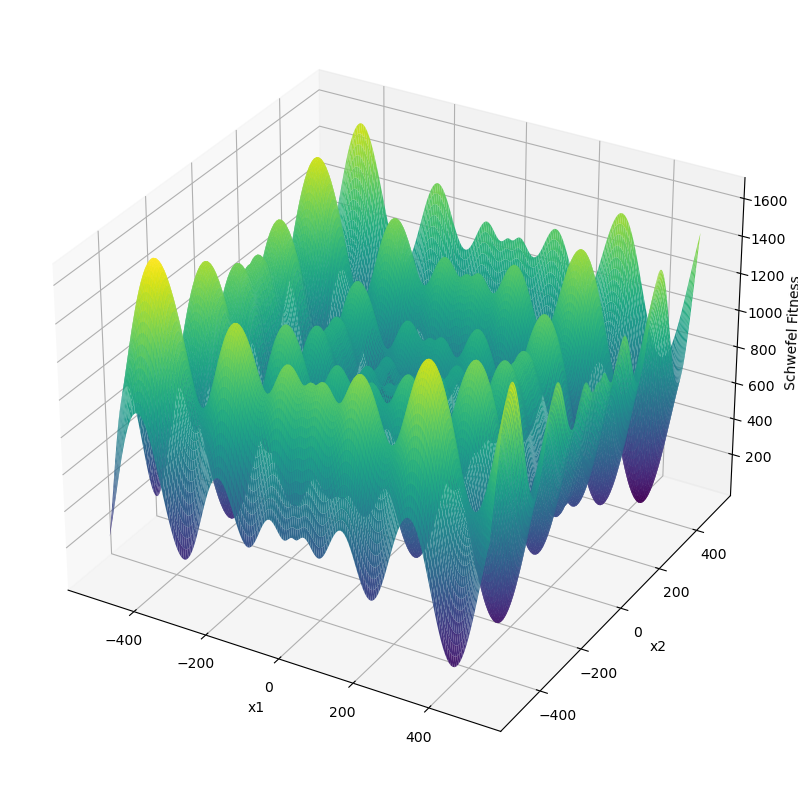

In [231]:
# Visualization of 2-Dimensional Schwefel function (3-D Fitness landscape visualization)
# Schwefel function modified for graphing convenience
def schwefel2(x, y):  
    return (418.98291*2) - ((x*np.sin(np.sqrt(np.absolute(x))))+(y*np.sin(np.sqrt(np.absolute(y)))))

x1 = np.linspace(-512, 512, 200)
x2 = np.linspace(-512, 512, 200)

X1, X2 = np.meshgrid(x1, x2)
results = schwefel2(X1, X2)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, results, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Schwefel Fitness')
plt.show()

## Real-Valued GA Approach
- Representation and Population: 100 randomly generated lists of 10 real numbers.
- Parents selected via Tournament Selection (n=2)
- Crossover (Pc = 0.9): 
    - Whole Arithmetic - Randomly mixing parents' bits
    - Uniform - Randomly choosing parents' bits
- Mutation (Pm = 1/10 = 0.1): Uniform
- Survivor Selection: Top 100 of Parents+Offspring pool
- Run for 500 generations and see how close we get.

In [232]:
# Population Init for 100 randomly generated genotypes
population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]

# This line sorts our population by the values of its schwefel fitness value
population.sort(key=schwefel)
# Access scores via [schwefel(i) for i in population]

In [233]:
# Mutation Operator - Mutating each number in a chromosome by randomly selecting another number in range

# Toggle parameters here
mrate = 0.1 # Per bit

# Takes in one chromosome and mutates each gene
def mutate(geno):
    return [random.uniform(-512, 512) if(random.uniform(0,1)<=mrate) else i for i in geno]
# Mutate with [mutate(i) for i in population]

In [234]:
# Crossover Operator - Taking 2 chromosomes and doing uniform whole arithmetic recombination

# Uniform, so crossover parameter is 0.5. Takes equal influence from both parents, returns identical children
alpha = 0.5
xrate = 0.9 # Per crossover operation, else copy parents

# Takes in two chromosomes and returns two new chromosomes
def cross(geno1, geno2):
    if(random.uniform(0,1)<=xrate):
        child1 = [alpha*geno1[i]+(1-alpha)*geno2[i] for i in range(len(geno1))]
        child2 = [alpha*geno2[i]+(1-alpha)*geno1[i] for i in range(len(geno2))]
        return [child1, child2]
    return [geno1, geno2]
# Add to population with population+cross(a,b)

# Uniform crossover - Randomly select genes from one and the other should be a mirror of what the other is. For example:
# [1,2,1,2,2,1]
# [2,1,2,1,1,2]
def unicross(geno1, geno2):
    parents = [geno1, geno2]
    if(random.uniform(0,1)<=xrate):
        rando = [random.randint(0,1) for i in range(len(geno1))]
        rando2 = [0 if i==1 else 1 for i in rando]
        child1 = [parents[rando[i]][i] for i in range(len(geno1))]
        child2 = [parents[rando2[i]][i] for i in range(len(geno2))]
        return [child1, child2]
    return [geno1, geno2]
# Add to population with population+unicross(a,b)

In [235]:
# Parent Selector - Tournament selection. Tournament participants are uniformly random, selection grabs top fitness
# Contestants picked without replacement, n = tournament size, replaced after tournament
n = 2

def parent_sel(population):
    # Cumulative sum of ranking probabilities used here for random choice selection
    
    parents = []
    
    # Repeat process twice to get 2 parents for reproduction
    for i in range(2):
        # Set up copy for easier management
        copy_pool = population.copy()
        
        # Pick n contestants without replacement and sort by fitness    
        tourn_pool = [copy_pool.pop(random.randint(0, len(copy_pool)-1)) for i in range(n)]
        tourn_pool.sort(key=schwefel)
        # Just grab the best
        parents = parents+[tourn_pool[0]]

    return parents
# Have crossover call with cross(*parents)

In [236]:
# Survival Selector - Parents and Offsprings competing together
psize = 100

# Deterministic selection: Just picks Top 100 by dropping the worst (highest fitness) instead of sorting the list
def det_surv(pop):
    pop.sort(key=schwefel)
    return pop[:psize]

In [237]:
# Main evolution loop: Takes in a Population and evolves it. Takes in a recorder list and records progress.
# Takes in a crossover function as a means of deciding how reproduction is done.
def realGA(population, recorder, crossover):
    # Each Generation:
    for i in range(500):
        # Make 100 Kids
        for i in range(50):
            # Parent Selection
            parents = parent_sel(population)

            # Variation Operators on Offspring
            children = crossover(*parents)
            children = [mutate(i) for i in children]
            population = population+children

        # Survival Selection
        population = det_surv(population)
        # Records Schwefel Score of best performer
        recorder.append(schwefel(population[0]))
    # Return results as a tuple after we're done
    return population, recorder
# Get population and recorder with results[0], results[1], respectively

Sorting is called 101 times per loop:
- Once on the *tournament pool* of size *n* every time we use tournament selection to select parents for offspring generation (100 times)
- Once on the *full population* of size *200* to sort the parent+offspring population for survival selection (1 time)

In [238]:
# ONE TRIAL EACH

# 4 Parameters to be set:
xrate = 0.9
alpha = 0.5
mrate = 0.1
n = 2

for i in range(2):
    label = ["Whole Arithmetic Crossover", "Uniform Crossover"]
    func = [cross, unicross]
    start_time = time.time()

    # Initialize population and recorder
    population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]
    recorder=[]

    # Make sure to only run it once to save computing time
    results = realGA(population, recorder, func[i])

    population = results[0]
    print("---")
    print(f"{label[i]}")
    print(f"Number of records: {len(results[1])}")
    print("---")
    print(f"Best Chromosome: {population[0]}")
    print(f"Schwefel Score: {schwefel(population[0])}")
    print("--- %s seconds ---" % (time.time() - start_time))

---
Whole Arithmetic Crossover
Number of records: 500
---
Best Chromosome: [421.06276786746446, 421.3360905207717, 421.64374725974386, 420.88622547707524, 420.2260926495333, 421.37373794910866, 420.7040040851389, 421.53760130481953, 420.9470119756097, 420.96731998599716]
Schwefel Score: 0.21675378263626044
--- 6.09757661819458 seconds ---
---
Uniform Crossover
Number of records: 500
---
Best Chromosome: [420.6226942667166, 421.27631993086334, 419.9069993665829, 421.71953656888286, 420.6469117804294, 420.73784293095616, 421.5202577836444, 421.8450787732871, 422.1147311451158, 418.8798734873021]
Schwefel Score: 1.1115191442677315
--- 6.3565895557403564 seconds ---


In [239]:
# Function to run N trials + have DataFrame
def test_trials(n, crossover):
    data = []
    for trial in range(n):
        # Initialize population and recorder
        population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]
        # Keeping track of best performance over time for visualization purposes
        # Recorder keeps initialized performance as a reference
        f_progress = [min([schwefel(i) for i in population])]

        results = realGA(population, f_progress, crossover)

        # Get progress of ALL runs
        data.append(results[1])
    # Return DataFrame
    return pd.DataFrame(data)

# Remember to save as variable to not call this long code more than once

In [240]:
# Function that reports convergence
# Takes in some results, aggregates, and responds with time to converge to score N
def conv(df, n, cross, label, param):
    average_df = df.mean(axis=0).to_frame(name="Fit")
    
    # Conditional exists because it's very possible the algorithm won't converge in time or converge at all
    if (len(average_df[average_df['Fit']<n])>0):
        print(f"On average, a Genetic Algorithm using {cross} with a {label} of {param} reaches Schwefel < {n} at Generation {average_df[average_df['Fit']<n].iloc[0].name}")
    else:
        print(f"On average, a Genetic Algorithm using {cross} with a {label} of {param} did not reach Schwefel < {n} within the time limit") 

In [241]:
# Default Parameters used. 30 Trials - Whole Arithmetic Crossover

start_time = time.time()

data_df = test_trials(30, cross)

print("--- %s seconds ---" % (time.time() - start_time))

--- 184.09548664093018 seconds ---


In [242]:
# We can visualize the table like so
data_df.index += 1
data_df.index.name = "Trial Number"
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
Trial Number,,,,,,,,,,,,,,,,,,,,,
1,2920.001867,2920.001867,2920.001867,2920.001867,2920.001867,2920.001867,2846.536644,2320.607299,2320.607299,2320.607299,...,1.472724,1.472724,1.472724,1.472724,1.472724,1.472724,1.472724,1.472724,1.472724,1.472724
2,2680.657280,2680.657280,2680.657280,2680.657280,2680.657280,2680.657280,2680.657280,2680.657280,2680.657280,2640.991403,...,0.496807,0.496807,0.496807,0.496807,0.496807,0.496807,0.496807,0.496807,0.496807,0.496807
3,2876.746858,2830.799327,2830.799327,2830.799327,2541.219495,2541.219495,2541.219495,2541.219495,2541.219495,2284.944886,...,1.354517,1.354517,1.354517,1.354517,1.354517,1.354517,1.354517,1.344790,1.344790,1.344790
4,2216.621505,2216.621505,2216.621505,2216.621505,2216.621505,2216.621505,2216.621505,2216.621505,2216.621505,2216.621505,...,0.597763,0.597763,0.597399,0.597399,0.597399,0.597399,0.597399,0.596931,0.596633,0.596591
5,2897.183485,2830.684200,2830.684200,2830.684200,2830.684200,2830.684200,2830.684200,2600.994699,2550.324455,2550.324455,...,0.714717,0.714717,0.714717,0.714717,0.714717,0.714717,0.714717,0.714717,0.714717,0.714717


In [243]:
# We can also see the average trajectory of each of these runs and see how long it takes for them to converge
conv(data_df, 10, "Whole Arithmetic Crossover", "Parameter Set", "DEFAULT")

On average, a Genetic Algorithm using Whole Arithmetic Crossover with a Parameter Set of DEFAULT reaches Schwefel < 10 at Generation 272


In [244]:
# Default Parameters used. 30 Trials - Uniform Crossover

start_time = time.time()

data2_df = test_trials(30, unicross)

print("--- %s seconds ---" % (time.time() - start_time))

--- 189.66965126991272 seconds ---


In [245]:
# We can visualize the table like so
data2_df.index += 1
data2_df.index.name = "Trial Number"
data2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
Trial Number,,,,,,,,,,,,,,,,,,,,,
1,2511.047318,2511.047318,2353.482442,1712.852536,1573.552313,1027.890225,986.713833,793.903682,793.903682,771.342743,...,0.098661,0.098661,0.098661,0.098661,0.098661,0.098661,0.098661,0.098661,0.098661,0.098661
2,2594.838359,2594.838359,2236.210971,1960.207931,1921.043318,1317.315859,1194.171198,1036.201296,756.100249,727.855096,...,0.146054,0.146054,0.146054,0.146054,0.146054,0.146054,0.146054,0.146054,0.146054,0.146054
3,2117.395589,2117.395589,2117.395589,1962.730048,1962.730048,1520.474743,1174.793830,979.957589,979.957589,922.844761,...,0.296738,0.296738,0.296738,0.296738,0.296738,0.296738,0.205184,0.205184,0.205184,0.205184
4,2190.122239,2190.122239,1928.510721,1580.032575,1366.801634,1038.666733,886.033762,886.033762,643.052705,548.350324,...,0.180839,0.180839,0.180839,0.180839,0.180839,0.180839,0.180839,0.180839,0.180839,0.180839
5,2639.931433,2421.902429,2119.508581,1710.904538,1571.750074,1408.729611,870.861235,767.758619,767.758619,586.536571,...,0.244455,0.244455,0.244455,0.244455,0.244455,0.244455,0.244455,0.244455,0.244455,0.244455


In [246]:
# We can also see the average trajectory of each of these runs and see how long it takes for them to converge
conv(data2_df, 10, "Uniform Crossover", "Parameter Set", "DEFAULT")

On average, a Genetic Algorithm using Uniform Crossover with a Parameter Set of DEFAULT reaches Schwefel < 10 at Generation 98


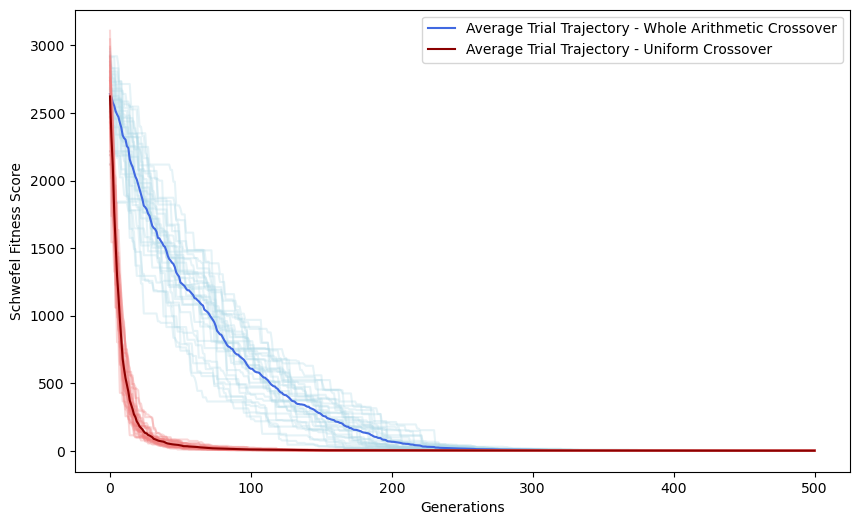

In [247]:
# Of course, we can also graph the results
for i in range(30):
    data_df.iloc[i].plot(color="lightblue", label="_nolegend_", alpha=0.3)
data_df.mean(axis=0).plot(color="royalblue", label="Average Trial Trajectory - Whole Arithmetic Crossover")
for i in range(30):
    data2_df.iloc[i].plot(color="lightcoral", label="_nolegend_", alpha=0.3)
data2_df.mean(axis=0).plot(color="darkred", label="Average Trial Trajectory - Uniform Crossover")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Generations")
plt.legend()
plt.show()

### Parameter Tuning

For simplicity's sake:
- "WA" = "Whole Arithmetic Crossover", "UC" = "Uniform Crossover"
- "TS" = "Tournament Size"
- "MR" = "Mutation Rate"
- "CR" = "Crossover Rate"
- "AV" = "Crossover Alpha Value"

In [248]:
# Label Crossover Method
crosses=[[cross, "WA"] for i in range(5)]+[[unicross, "UC"] for i in range(5)]
# Graph visualization colors
color=["#006400", "#00008b", "#00ffff", "#6495ed", "#00ff00", "#b03060", "#ff0000", "#f4a460", "#ff00ff", "#ff4500"]

#### Tournament Sizes

On average, a Genetic Algorithm using WA with a Tournament Size of 2 reaches Schwefel < 10 at Generation 276
--- 183.9108555316925 seconds ---
On average, a Genetic Algorithm using WA with a Tournament Size of 6 reaches Schwefel < 10 at Generation 120
--- 350.1138594150543 seconds ---
On average, a Genetic Algorithm using WA with a Tournament Size of 10 reaches Schwefel < 10 at Generation 83
--- 520.4160606861115 seconds ---
On average, a Genetic Algorithm using WA with a Tournament Size of 15 reaches Schwefel < 10 at Generation 67
--- 736.7810416221619 seconds ---
On average, a Genetic Algorithm using WA with a Tournament Size of 20 reaches Schwefel < 10 at Generation 66
--- 939.8517968654633 seconds ---
On average, a Genetic Algorithm using UC with a Tournament Size of 2 reaches Schwefel < 10 at Generation 90
--- 191.45162153244019 seconds ---
On average, a Genetic Algorithm using UC with a Tournament Size of 6 reaches Schwefel < 10 at Generation 75
--- 361.4762313365936 seconds ---


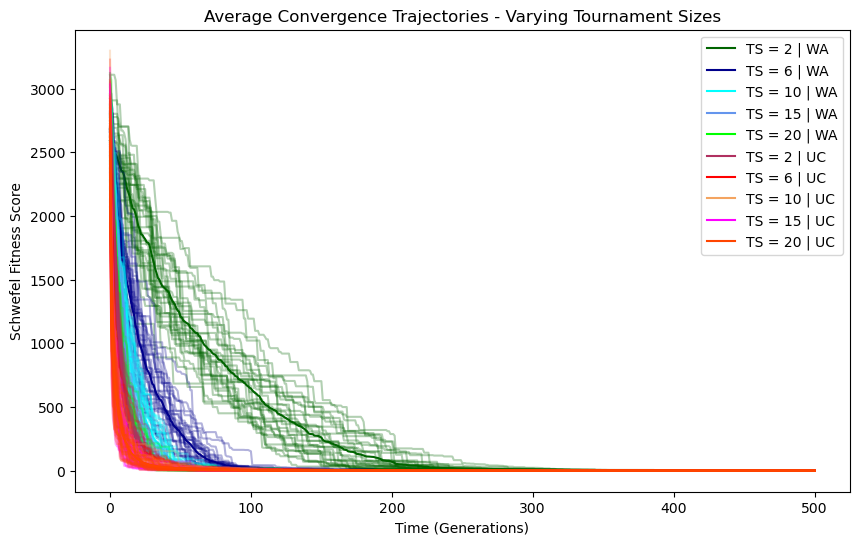

In [250]:
# This time, with varying Tournament Sizes
tsizes=[2, 6, 10, 15, 20]*2

# Test different conditions
for test in range(len(tsizes)):
    # Change Parameters per Test Bundle
    start_time = time.time()
    n = tsizes[test]
    crossover=crosses[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30, crossover[0])
    # Report Convergence
    conv(data_df, 10, crossover[1], "Tournament Size", n)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test], label="_nolegend_", alpha=0.3)
    data_df.mean(axis=0).plot(color=color[test], label=f"TS = {n} | {crossover[1]}")

plt.title("Average Convergence Trajectories - Varying Tournament Sizes")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
n=2

#### Crossover Rates

On average, a Genetic Algorithm using WA with a Crossover Rate of 0.2 reaches Schwefel < 10 at Generation 166
--- 181.41728377342224 seconds ---
On average, a Genetic Algorithm using WA with a Crossover Rate of 0.4 reaches Schwefel < 10 at Generation 162
--- 181.7620232105255 seconds ---
On average, a Genetic Algorithm using WA with a Crossover Rate of 0.6 reaches Schwefel < 10 at Generation 174
--- 182.70688009262085 seconds ---
On average, a Genetic Algorithm using WA with a Crossover Rate of 0.9 reaches Schwefel < 10 at Generation 236
--- 183.20305800437927 seconds ---
On average, a Genetic Algorithm using WA with a Crossover Rate of 1.0 reaches Schwefel < 10 at Generation 266
--- 182.69333505630493 seconds ---
On average, a Genetic Algorithm using UC with a Crossover Rate of 0.2 reaches Schwefel < 10 at Generation 137
--- 184.01681113243103 seconds ---
On average, a Genetic Algorithm using UC with a Crossover Rate of 0.4 reaches Schwefel < 10 at Generation 113
--- 183.0542359352111

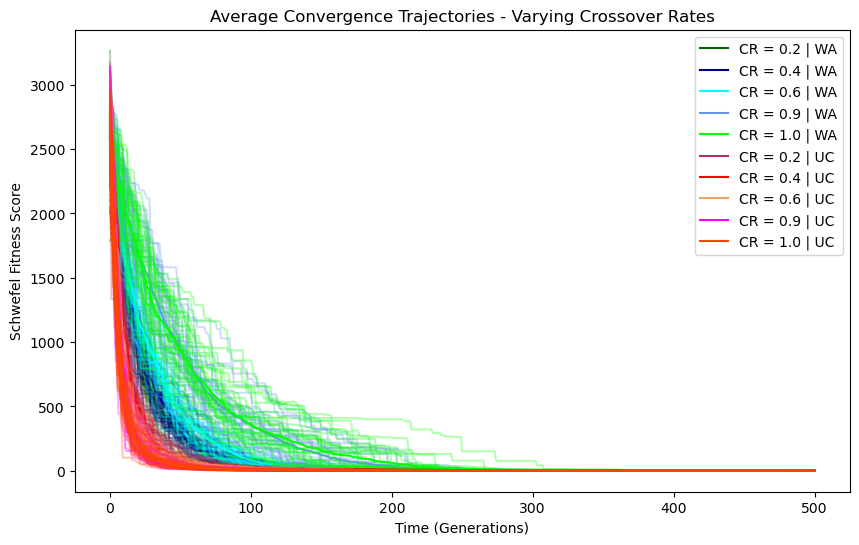

In [254]:
# This time, with varying Crossover Rates
tsizes=[0.2, 0.4, 0.6, 0.9, 1.0]*2

# Test different conditions
for test in range(len(tsizes)):
    # Change Parameters per Test Bundle
    start_time = time.time()
    xrate = tsizes[test]
    crossover=crosses[test]
    
    # Plot Results of each Test Bundle
    data_df = test_trials(30, crossover[0])
    # Report Convergence
    conv(data_df, 10, crossover[1], "Crossover Rate", xrate)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test], label="_nolegend_", alpha=0.3)
    data_df.mean(axis=0).plot(color=color[test], label=f"CR = {xrate} | {crossover[1]}")

plt.title("Average Convergence Trajectories - Varying Crossover Rates")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
xrate=0.9

#### Mutation Rates

On average, a Genetic Algorithm using WA with a Mutation Rate of 0.0 did not reach Schwefel < 10 within the time limit
--- 183.41690301895142 seconds ---
On average, a Genetic Algorithm using WA with a Mutation Rate of 0.1 reaches Schwefel < 10 at Generation 216
--- 183.5231056213379 seconds ---
On average, a Genetic Algorithm using WA with a Mutation Rate of 0.3 did not reach Schwefel < 10 within the time limit
--- 186.40750765800476 seconds ---
On average, a Genetic Algorithm using WA with a Mutation Rate of 0.5 did not reach Schwefel < 10 within the time limit
--- 184.79725313186646 seconds ---
On average, a Genetic Algorithm using WA with a Mutation Rate of 0.7 did not reach Schwefel < 10 within the time limit
--- 186.92500042915344 seconds ---
On average, a Genetic Algorithm using UC with a Mutation Rate of 0.0 did not reach Schwefel < 10 within the time limit
--- 189.51299357414246 seconds ---
On average, a Genetic Algorithm using UC with a Mutation Rate of 0.1 reaches Schwefel <

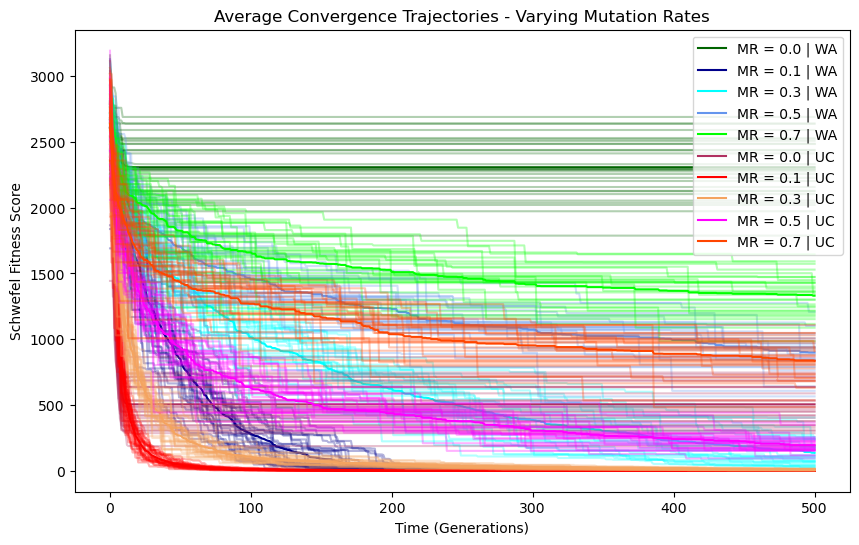

In [255]:
# This time, with varying Mutation Rates
tsizes=[0.0, 0.1, 0.3, 0.5, 0.7]*2

# Test different conditions
for test in range(len(tsizes)):
    # Change Parameters per Test Bundle
    start_time = time.time()
    mrate = tsizes[test]
    crossover=crosses[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30, crossover[0])
    # Report Convergence
    conv(data_df, 10, crossover[1], "Mutation Rate", mrate)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test], label="_nolegend_", alpha=0.3)
    data_df.mean(axis=0).plot(color=color[test], label=f"MR = {mrate} | {crossover[1]}")

plt.title("Average Convergence Trajectories - Varying Mutation Rates")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
mrate=0.1

#### Alpha Values

On average, a Genetic Algorithm using WA with a Alpha Value of 0.0 reaches Schwefel < 10 at Generation 171
--- 186.3265450000763 seconds ---
On average, a Genetic Algorithm using WA with a Alpha Value of 0.125 reaches Schwefel < 10 at Generation 248
--- 182.77158737182617 seconds ---
On average, a Genetic Algorithm using WA with a Alpha Value of 0.25 reaches Schwefel < 10 at Generation 270
--- 184.03654861450195 seconds ---
On average, a Genetic Algorithm using WA with a Alpha Value of 0.375 reaches Schwefel < 10 at Generation 287
--- 187.33583402633667 seconds ---
On average, a Genetic Algorithm using WA with a Alpha Value of 0.5 reaches Schwefel < 10 at Generation 273
--- 182.1251039505005 seconds ---


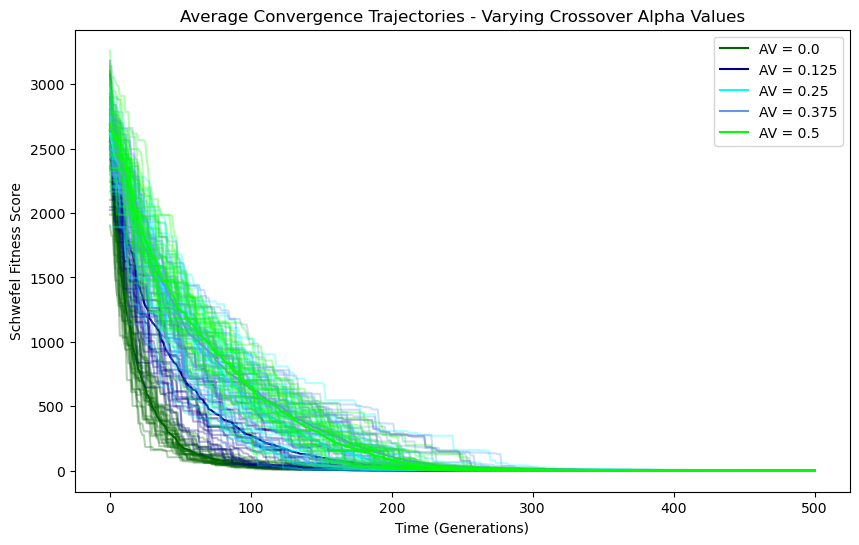

In [259]:
# This time, with varying Crossover Alpha Values
# As Uniform Crossover doesn't have an Alpha value, we'll only be examining this parameter's effect on Whole Arithmetic Crossover
# We only need to test half of the parameter range as alpha=0.1 creates the same children as alpha=0.9 but in a different order
tsizes=[0.0, 0.125, 0.25, 0.375, 0.5]

# Test different conditions
for test in range(5):
    # Change Parameters per Test Bundle
    start_time = time.time()
    alpha = tsizes[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30, cross)
    # Report Convergence
    conv(data_df, 10, "WA", "Alpha Value", alpha)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test], label="_nolegend_", alpha=0.3)
    data_df.mean(axis=0).plot(color=color[test], label=f"AV = {alpha}")

plt.title("Average Convergence Trajectories - Varying Crossover Alpha Values")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
alpha = 0.5

#### Both Crossover Rate and Alpha Value

On average, a Genetic Algorithm using WA with a AV|CR of 0.0|0.2 reaches Schwefel < 10 at Generation 185
--- 183.1473741531372 seconds ---
On average, a Genetic Algorithm using WA with a AV|CR of 0.125|0.2 reaches Schwefel < 10 at Generation 156
--- 180.94866371154785 seconds ---
On average, a Genetic Algorithm using WA with a AV|CR of 0.25|0.2 reaches Schwefel < 10 at Generation 166
--- 181.13256764411926 seconds ---
On average, a Genetic Algorithm using WA with a AV|CR of 0.375|0.2 reaches Schwefel < 10 at Generation 147
--- 184.84425711631775 seconds ---
On average, a Genetic Algorithm using WA with a AV|CR of 0.5|0.2 reaches Schwefel < 10 at Generation 149
--- 181.84221577644348 seconds ---
On average, a Genetic Algorithm using WA with a AV|CR of 0.0|0.4 reaches Schwefel < 10 at Generation 182
--- 180.3082230091095 seconds ---
On average, a Genetic Algorithm using WA with a AV|CR of 0.125|0.4 reaches Schwefel < 10 at Generation 158
--- 181.41558599472046 seconds ---
On average, a G

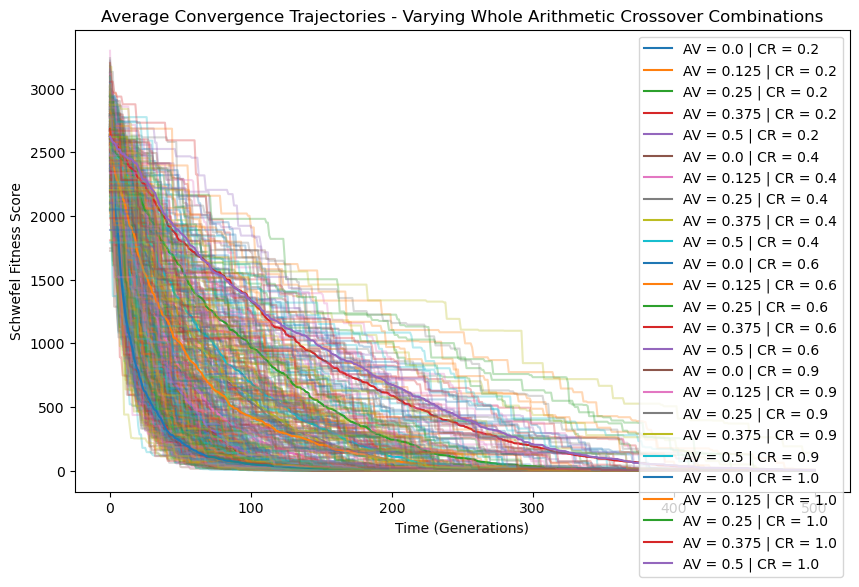

In [263]:
# This time, with varying Crossover Alpha Values
# As Uniform Crossover doesn't have an Alpha value, we'll only be examining this parameter's effect on Whole Arithmetic Crossover
# We only need to test half of the parameter range as alpha=0.1 creates the same children as alpha=0.9 but in a different order
tsizes=[0.0, 0.125, 0.25, 0.375, 0.5]
xsizes=[0.2, 0.4, 0.6, 0.9, 1.0]

for x in range(5):
    xrate = xsizes[x]
    # Test different conditions
    for test in range(5):
        # Change Parameters per Test Bundle
        start_time = time.time()
        alpha = tsizes[test]

        # Plot Results of each Test Bundle
        data_df = test_trials(30, cross)
        # Report Convergence
        conv(data_df, 10, "WA", "AV|CR", f"{alpha}|{xrate}")

        print("--- %s seconds ---" % (time.time() - start_time))

        # Graph results, needs to be on the same DataFrame for results to be on the same chart
        for i in range(30):
            data_df.iloc[i].plot(label="_nolegend_", alpha=0.3)
        data_df.mean(axis=0).plot(label=f"AV = {alpha} | CR = {xrate}")

plt.title("Average Convergence Trajectories - Varying Whole Arithmetic Crossover Combinations")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
alpha = 0.5
xrate = 0.9

## Binary GA Approach
- Representation and Population: 100 randomly generated lists of 10 binary numbers.
- Parents selected via Tournament Selection (n=2)
- Crossover (Pc = 0.9): 
    - Uniform: Exchanges every other bit with other parent
    - 2-Point: Exchanges random segment with other parent
- Mutation (Pm = 1/100 = 0.01): Bit-flip
- Survivor Selection: Parents+Offspring
- Run for 500 generations and see how close we get.

In [337]:
# Population Init for 100 randomly generated genotypes
# Define each number as binary string from "0000000000" to "1111111111", or 0~1023 when evaluated
# Subtract range by 512 to get -512~511

# Each chromosome then will have 10 lists of 10 characters
population = [[[str(random.randint(0, 1)) for i in range(10)] for i in range(10)] for i in range(100)]

# Numerical conversion can be found with [[int("".join(charlist), 2)-512 for charlist in geno] for geno in population]
# Each chromosome of 10 lists of characters is compressed into 10 binary strings and then converted into 10 integers

# Modified schwefel function for binary strings
# Schwefel should be closest to 0 when each value is 1110100101 (421 in our representation)
def binwefel(list_list):
    new_list = [int("".join(charlist), 2)-512 for charlist in list_list]
    return (418.98291*len(new_list)) - np.sum([x*np.sin(np.sqrt(np.absolute(x)))for x in new_list])

# This line sorts our population by the values of its schwefel fitness value
population.sort(key=binwefel)
# Access scores via [binwefel(i) for i in population]

In [338]:
binwefel([["1", "1", "1", "0", "1", "0", "0", "1", "0", "1"] for i in range(10)])

0.0014598385569115635

In [339]:
# Mutation Operator - Mutating each number in a chromosome by randomly flipping 0s to 1s and 1s to 0s

# Toggle parameters here
mrate = 0.01 # Per bit

# Takes in one chromosome and mutates each gene
def bmutate(geno):
    return [[("0" if i=="1" else "1") if(random.uniform(0,1)<=mrate) else i for i in string] for string in geno]
# Mutate with [bmutate(i) for i in population]

In [378]:
# Crossover Operator - Taking 2 chromosomes and doing uniform whole arithmetic recombination

# Uniform, so crossover parameter is 0.5. Takes equal influence from both parents, returns identical children
xrate = 0.9 # Per crossover operation, else copy parents

# Takes in two chromosomes and returns two new chromosomes
def bcross(geno1, geno2):
    # Using len() instead of len-1 because colon operators exclude end point
    trange = [i for i in range(1, len(geno1))]
    twopoint = [trange.pop(random.randint(0, len(trange)-1)) for i in range(2)]
    twopoint.sort()
    if(random.uniform(0,1)<=xrate):
        child1 = geno1[:twopoint[0]]+geno2[twopoint[0]:twopoint[1]]+geno1[twopoint[1]:]
        child2 = geno2[:twopoint[0]]+geno1[twopoint[0]:twopoint[1]]+geno2[twopoint[1]:]
        return [child1, child2]
    return [geno1, geno2]

def bunicross(geno1, geno2):
    parents = [geno1, geno2]
    if(random.uniform(0,1)<=xrate):
        rando = [random.randint(0,1) for i in range(len(geno1))]
        rando2 = [0 if i==1 else 1 for i in rando]
        child1 = [parents[rando[i]][i] for i in range(len(geno1))]
        child2 = [parents[rando2[i]][i] for i in range(len(geno2))]
        return [child1, child2]
    return [geno1, geno2]
# Add to population with population+cross(a,b)

In [379]:
# Parent Selector - Tournament selection. Tournament participants are uniformly random, selection grabs top fitness
# Contestants picked without replacement, n = tournament size, replaced after tournament
n = 2

def bparent_sel(population):
    
    parents = []
    
    # Repeat process twice to get 2 parents for reproduction
    for i in range(2):
        # Set up copy for easier management
        copy_pool = population.copy()
        
        # Pick n contestants without replacement and sort by fitness    
        tourn_pool = [copy_pool.pop(random.randint(0, len(copy_pool)-1)) for i in range(n)]
        tourn_pool.sort(key=binwefel)
        # Just grab the best
        parents = parents+[tourn_pool[0]]

    return parents
# Have crossover call with cross(*parents)

In [380]:
# Survival Selector - Parents and Offsprings competing together
psize = 100

# Deterministic selection: Just picks Top 100 by dropping the worst (highest fitness) instead of sorting the list
def bin_surv(pop):
    pop.sort(key=binwefel)
    return pop[:psize]

In [381]:
# Main evolution loop: Takes in a Population and evolves it. Takes in a recorder list and records progress.
# Takes in a crossover function as a means of deciding how reproduction is done.
def binGA(population, recorder, crossover):
    # Each Generation:
    for i in range(500):
        # Make 100 Kids
        for i in range(50):
            # Parent Selection
            parents = bparent_sel(population)

            # Variation Operators on Offspring
            children = crossover(*parents)
            children = [bmutate(i) for i in children]
            population = population+children

        # Survival Selection
        population = bin_surv(population)
        # Records Schwefel Score of best performer
        recorder.append(binwefel(population[0]))
    # Return results as a tuple after we're done
    return population, recorder
# Get population and recorder with results[0], results[1], respectively

Sorting is called 101 times per loop:
- Once on the *tournament pool* of size *n* every time we use tournament selection to select parents for offspring generation (100 times)
- Once on the *full population* of size *200* to sort the parent+offspring population for survival selection (1 time)

In [382]:
# ONE TRIAL EACH

# 4 Parameters to be set:
xrate = 0.9
alpha = 0.5
mrate = 0.01
n = 2

for i in range(2):
    label = ["2-Point Crossover", "Uniform Crossover"]
    func = [bcross, bunicross]
    start_time = time.time()

    # Initialize population and recorder
    population = [[[str(random.randint(0, 1)) for i in range(10)] for i in range(10)] for i in range(100)]
    recorder=[]

    # Make sure to only run it once to save computing time
    results = binGA(population, recorder, func[i])

    population = results[0]
    print("---")
    print(f"{label[i]}")
    print(f"Number of records: {len(results[1])}")
    print("---")
    print(f"Best Chromosome: {population[0]}")
    print(f"Schwefel Score: {binwefel(population[0])}")
    print("--- %s seconds ---" % (time.time() - start_time))

---
2-Point Crossover
Number of records: 500
---
Best Chromosome: [['1', '1', '1', '0', '1', '0', '0', '1', '0', '1'], ['1', '1', '1', '0', '1', '0', '0', '1', '0', '1'], ['1', '1', '1', '0', '0', '1', '1', '1', '1', '1'], ['1', '1', '1', '0', '0', '1', '1', '1', '1', '1'], ['1', '1', '1', '0', '1', '0', '0', '1', '0', '1'], ['1', '1', '1', '0', '0', '1', '1', '1', '1', '1'], ['1', '1', '1', '0', '0', '1', '1', '1', '1', '1'], ['1', '1', '1', '0', '1', '0', '0', '1', '0', '1'], ['1', '1', '1', '0', '1', '0', '0', '1', '0', '1'], ['1', '1', '1', '0', '1', '0', '0', '1', '0', '1']]
Schwefel Score: 17.908999129212134
--- 9.164331674575806 seconds ---
---
Uniform Crossover
Number of records: 500
---
Best Chromosome: [['1', '1', '1', '0', '1', '0', '0', '1', '0', '1'], ['1', '1', '1', '0', '1', '0', '0', '1', '0', '1'], ['1', '1', '1', '0', '1', '0', '0', '1', '0', '1'], ['1', '1', '1', '0', '1', '0', '0', '1', '0', '1'], ['1', '1', '1', '0', '1', '0', '0', '1', '0', '1'], ['1', '1', '1', '

In [383]:
# Function to run N trials + have DataFrame
def bin_trials(n, crossover):
    data = []
    for trial in range(n):
        # Initialize population and recorder
        population = [[[str(random.randint(0, 1)) for i in range(10)] for i in range(10)] for i in range(100)]
        # Keeping track of best performance over time for visualization purposes
        # Recorder keeps initialized performance as a reference
        f_progress = [min([binwefel(i) for i in population])]

        results = binGA(population, f_progress, crossover)

        # Get progress of ALL runs
        data.append(results[1])
    # Return DataFrame
    return pd.DataFrame(data)

# Remember to save as variable to not call this long code more than once

In [384]:
# Default Parameters used. 30 Trials

start_time = time.time()

data_df = bin_trials(30, bcross)

print("--- %s seconds ---" % (time.time() - start_time))

--- 272.8357410430908 seconds ---


In [385]:
# We can visualize the table like so
data_df.index += 1
data_df.index.name = "Trial Number"
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
Trial Number,,,,,,,,,,,,,,,,,,,,,
1,2248.048882,1985.946151,1393.459512,1393.459512,1229.385889,1188.043427,1054.078967,813.329990,772.948483,662.510988,...,365.866908,365.866908,365.866908,365.866908,365.866908,365.866908,365.866908,365.866908,365.866908,365.866908
2,2482.150492,2311.177923,1775.438198,1608.137739,1426.404093,1368.727228,1104.064493,937.582623,718.401288,587.034837,...,127.422030,127.422030,127.422030,127.422030,127.422030,127.422030,127.422030,127.422030,127.422030,127.422030
3,2459.898456,2269.954511,1915.450995,1191.340130,1191.340130,1109.794045,964.199720,756.120032,526.231228,479.753027,...,136.375799,136.375799,136.375799,136.375799,136.375799,136.375799,136.375799,136.375799,136.375799,136.375799
4,2933.149984,1847.232864,1847.232864,1651.872217,1384.377705,1263.937972,1183.983717,966.516980,763.421825,763.421825,...,242.159857,242.159857,242.159857,242.159857,242.159857,242.159857,242.159857,242.159857,242.159857,242.159857
5,2750.289780,2650.564923,2256.856161,2033.942625,1340.346954,1340.346954,1313.428862,1147.940567,1052.701930,878.348583,...,128.169941,128.169941,128.169941,128.169941,128.169941,128.169941,128.169941,128.169941,128.169941,128.169941


In [386]:
# We can also see the average trajectory of each of these runs and see how long it takes for them to converge
conv(data_df, 10, "Two-Point Crossover", "Parameter Set", "DEFAULT")

On average, a Genetic Algorithm using Two-Point Crossover with a Parameter Set of DEFAULT did not reach Schwefel < 10 within the time limit


In [387]:
# Default Parameters used. 30 Trials - Uniform Crossover

start_time = time.time()

data2_df = bin_trials(30, bunicross)

print("--- %s seconds ---" % (time.time() - start_time))

--- 278.5146839618683 seconds ---


In [388]:
# We can visualize the table like so
data2_df.index += 1
data2_df.index.name = "Trial Number"
data2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
Trial Number,,,,,,,,,,,,,,,,,,,,,
1,2417.204516,2065.923871,1084.023428,1084.023428,685.523769,650.516050,442.565029,301.296016,301.296016,140.767457,...,13.432114,13.432114,13.432114,13.432114,13.432114,13.432114,13.432114,13.432114,13.432114,13.432114
2,2653.760446,2551.541609,2175.455196,1643.760536,1172.604212,1172.604212,972.911529,972.911529,735.048576,410.634638,...,8.955229,8.955229,8.955229,8.955229,8.955229,8.955229,8.955229,8.955229,8.955229,8.955229
3,2558.790238,2558.790238,1929.119555,1853.086487,1673.595227,1502.550133,1228.533870,951.639013,922.886644,869.812379,...,131.898914,131.898914,131.898914,131.898914,131.898914,131.898914,131.898914,131.898914,131.898914,131.898914
4,2049.796142,2049.796142,2049.796142,1387.848486,910.389353,671.597512,566.336826,382.387381,382.387381,382.387381,...,4.478345,4.478345,4.478345,4.478345,4.478345,4.478345,4.478345,4.478345,4.478345,4.478345
5,2864.606801,2083.558498,2080.938331,1397.576743,1002.504026,1002.504026,692.917387,692.917387,624.872501,504.531410,...,22.385884,22.385884,22.385884,22.385884,22.385884,22.385884,22.385884,22.385884,22.385884,22.385884


In [389]:
# We can also see the average trajectory of each of these runs and see how long it takes for them to converge
conv(data2_df, 10, "Uniform Crossover", "Parameter Set", "DEFAULT")

On average, a Genetic Algorithm using Uniform Crossover with a Parameter Set of DEFAULT did not reach Schwefel < 10 within the time limit


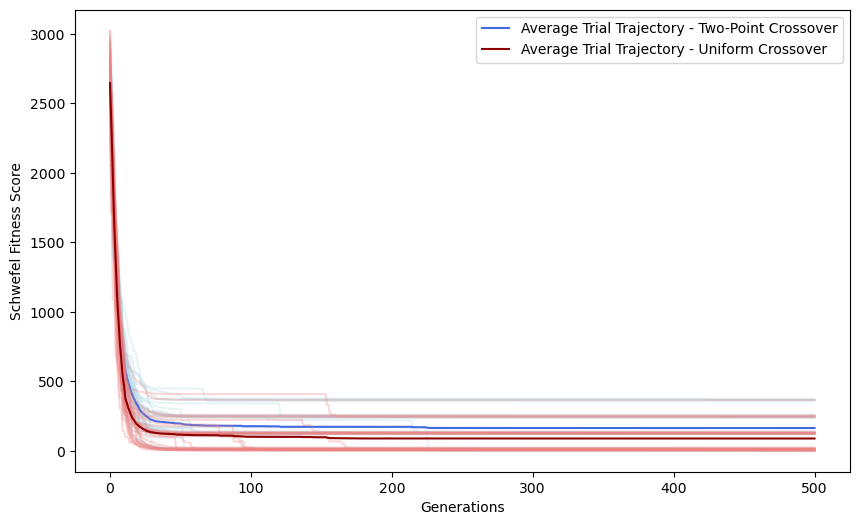

In [390]:
# Of course, we can also graph the results
for i in range(30):
    data_df.iloc[i].plot(color="lightblue", label="_nolegend_", alpha=0.3)
data_df.mean(axis=0).plot(color="royalblue", label="Average Trial Trajectory - Two-Point Crossover")
for i in range(30):
    data2_df.iloc[i].plot(color="lightcoral", label="_nolegend_", alpha=0.3)
data2_df.mean(axis=0).plot(color="darkred", label="Average Trial Trajectory - Uniform Crossover")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Generations")
plt.legend()
plt.show()